In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('../data/lab_8/Sunspots.csv')
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [5]:
frame = pd.DataFrame({
    'value': data['Monthly Mean Total Sunspot Number'].to_numpy()
}, index=pd.DatetimeIndex(data['Date']))

In [6]:
frame.head()

,value
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [7]:
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [8]:
frame.head()

,value
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [9]:
series = data['Monthly Mean Total Sunspot Number'].to_numpy()

In [10]:
time = data['Unnamed: 0'].to_numpy()

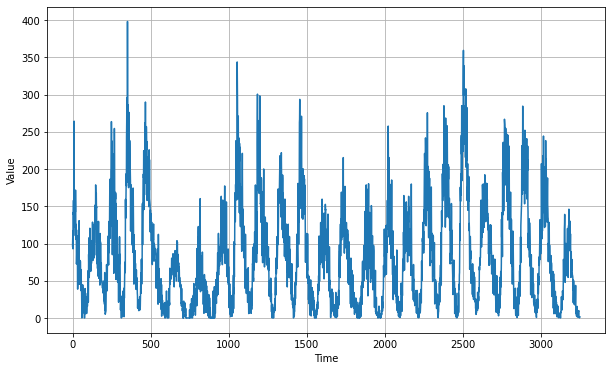

In [11]:
start = 0
end = None
plt.figure(figsize=(10, 6))
plt.plot(time[start:end], series[start:end], '-')
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [12]:
frame.head()

,value
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

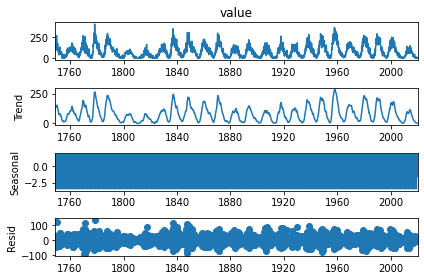

In [14]:
result_add = seasonal_decompose(frame['value'], model='additive', extrapolate_trend='freq')
result_add.plot()
plt.show()

In [15]:
from pandas.plotting import autocorrelation_plot

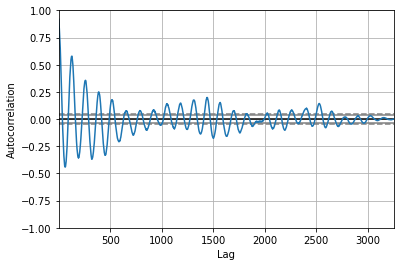

In [16]:
autocorrelation_plot(frame.value.tolist())

In [17]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [21]:
x_train.shape

(2500,)

In [22]:
x_valid.shape

(752,)

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
model = ARIMA(series, order=(5,1,0))

In [25]:
model_fit = model.fit(disp=0)

In [26]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3251
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -15102.868
Method:                       css-mle   S.D. of innovations             25.194
Date:                Tue, 14 Apr 2020   AIC                          30219.737
Time:                        21:20:42   BIC                          30262.344
Sample:                             1   HQIC                         30235.000
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0317      0.213     -0.149      0.882      -0.449       0.386
ar.L1.D.y     -0.4152      0.018    -23.719      0.000      -0.450      -0.381
ar.L2.D.y     -0.2979      0.019    -15.777      0.0

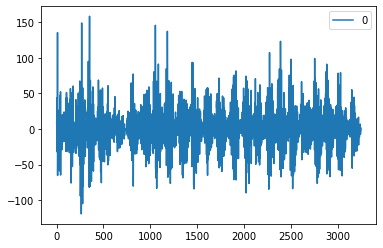

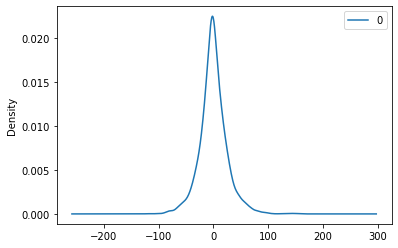

                 0
count  3251.000000
mean      0.003868
std      25.198623
min    -119.111207
25%     -13.116087
50%      -0.897181
75%      12.472338
max     158.110167


In [29]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [18]:
import tensorflow as tf

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
# 1d convolutional neural network
# LSTM
# DNN
model = tf.keras.models.Sequential([
         tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
         tf.keras.layers.LSTM(64, return_sequences=True),
         tf.keras.layers.LSTM(64, return_sequences=True),
         tf.keras.layers.Dense(30, activation="relu"),
         tf.keras.layers.Dense(10, activation="relu"),
         tf.keras.layers.Dense(1),
         tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()



<DatasetV1Adapter shapes: ((?, ?, 1), (?, ?, 1)), types: (tf.float64, tf.float64)>
(2500,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_____________________________________________

In [19]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
10/10 [==============================] - 1s 119ms/step - loss: 328.1044 - mean_absolute_error: 328.5507
Epoch 2/100
10/10 [==============================] - 1s 65ms/step - loss: 323.5653 - mean_absolute_error: 323.9825
Epoch 3/100
10/10 [==============================] - 1s 80ms/step - loss: 315.9757 - mean_absolute_error: 317.0080
Epoch 4/100
10/10 [==============================] - 1s 111ms/step - loss: 308.0819 - mean_absolute_error: 308.5937
Epoch 5/100
10/10 [==============================] - 1s 70ms/step - loss: 298.3420 - mean_absolute_error: 299.3781
Epoch 6/100
10/10 [==============================] - 1s 68ms/step - loss: 289.5240 - mean_absolute_error: 289.7020
Epoch 7/100
10/10 [==============================] - 1s 81ms/step - loss: 279.0366 - mean_absolute_error: 279.8345
Epoch 8/100
10/10 [==============================] - 1s 85ms/step - loss: 269.0316 - mean_absolute_

10/10 [==============================] - 1s 86ms/step - loss: 21.8351 - mean_absolute_error: 22.3764
Epoch 70/100
10/10 [==============================] - 1s 86ms/step - loss: 22.9432 - mean_absolute_error: 23.3970
Epoch 71/100
10/10 [==============================] - 1s 69ms/step - loss: 21.0097 - mean_absolute_error: 21.5443
Epoch 72/100
10/10 [==============================] - 1s 81ms/step - loss: 21.0402 - mean_absolute_error: 21.6571
Epoch 73/100
10/10 [==============================] - 1s 94ms/step - loss: 22.6164 - mean_absolute_error: 22.6262
Epoch 74/100
10/10 [==============================] - 1s 96ms/step - loss: 25.4932 - mean_absolute_error: 25.7105
Epoch 75/100
10/10 [==============================] - 1s 93ms/step - loss: 23.4223 - mean_absolute_error: 23.8870
Epoch 76/100
10/10 [==============================] - 1s 93ms/step - loss: 22.6327 - mean_absolute_error: 23.2972
Epoch 77/100
10/10 [==============================] - 1s 97ms/step - loss: 25.0630 - mean_absolute_er